In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [108]:
start_time = time.time()

1 Исходные данные

In [109]:
dataset_z = 1
dataset_U = 1

# Фиксация генераторов случайных чисел
random_seed_1 = 2022
random_seed_2 = 1148
np.random.seed(random_seed_1)

# Число ЛЭП
N_powerlines = 5

# Число признаков для каждой ЛЭП (в общем случае - 6, в частных случаях - 3)
N_feat = 6

# Число строк (число измерений)
N_rows = 1000

# Взаимные сопротивления ЛЭП (точные значения коэффициентов регрессии)
z_powerlines = {
    'z(1)': (0.040 + 0.0060j, 0.038 + 0.0055j, 0.036 + 0.0050j, 0.035 + 0.0048j, 0.033 + 0.0045j, 0.030 + 0.0044j),
    'z(2)': (0.020 + 0.0025j, 0.018 + 0.0022j, 0.016 + 0.0020j, 0.015 + 0.0019j, 0.014 + 0.0016j, 0.012 + 0.0014j),
    'z(3)': (0.018 + 0.0022j, 0.016 + 0.0020j, 0.015 + 0.0018j, 0.013 + 0.0016j, 0.012 + 0.0015j, 0.011 + 0.0014j),
    'z(4)': (0.016 + 0.0020j, 0.014 + 0.0018j, 0.013 + 0.0016j, 0.010 + 0.0015j, 0.009 + 0.0014j, 0.008 + 0.0012j),
    'z(5)': (0.015 + 0.0018j, 0.014 + 0.0016j, 0.013 + 0.0015j, 0.011 + 0.0012j, 0.010 + 0.0012j, 0.009 + 0.0010j),
}

# Доли участков датасета с различными направлениями передачи энергии
data_size_1 = 0.35
data_size_2 = 0.25

# Начальные значения токов фазы А (на начало измерений) для участков датасета с различными направлениями передачи энергии
I_1 = {
    'A(1)': (200, 200),
    'A(2)': (125, 125),
    'A(3)': (220, 220),
    'A(4)': (300, 300),
    'A(5)': (170, 170),
}

delta_I_2 = {
    'A(1)': (-700, -700),
    'A(2)': (0, 0),
    'A(3)': (0, 0),
    'A(4)': (0, 0),
    'A(5)': (0, 0),
}

delta_I_3 = {
    'A(1)': (0, 0),
    'A(2)': (0, 0),
    'A(3)': (-800, -800),
    'A(4)': (0, 0),
    'A(5)': (0, 0),
}

# Коэффициенты увеличения начальных значений токов фазы А на конец измерений для каждой ЛЭП
k_current = {
    'k(1)': 1.1,
    'k(2)': 1.1,
    'k(3)': 1.1,
    'k(4)': 1.1,
    'k(5)': 1.1,
}

# Максимальное абсолютное значение шума напряжений (элементов вектора b_d)
noise_b = 0.0

# Отн. погрешности измерений значений токов (элементов матрицы A_h) и напряжений (элементов вектора b_d)
k_A = 0.010
k_b = 0.050

# Пути для записи датасетов
output_path_z = f'C:/Datasets/dataset_z_powerlines_{dataset_z}.xlsx'
output_path_dat_0 = f'C:/Datasets/dataset_voltage_0_{dataset_z}_{dataset_U}.xlsx'
output_path_dat = f'C:/Datasets/dataset_voltage_{dataset_z}_{dataset_U}.xlsx'

2 Запись точных коэффициентов регрессии z_powerlines в файл

In [110]:
df_z_powerlines = pd.DataFrame(z_powerlines)
df_z_powerlines.to_excel(output_path_z, index=False, float_format='%.20f')

3 Преобразование форматов исходных данных

3.1 Генерация начальных значений фазных токов ЛЭП (на начало измерений) для участков датасета с различными направлениями передачи энергии

In [111]:
# Комплексные операторы поворота фазных токов
b_rot = complex(-0.5, -1 * np.sqrt(3) / 2)
c_rot = complex(-0.5, np.sqrt(3) / 2)

def calculate_initial_currents(I_dict):
    A = ()
    I_full = {}

    for key in I_dict:
        values = I_dict[key]
        a1, a2 = values

        key_values = [a1, a1 * b_rot, a1 * c_rot, 
                      a2, a2 * b_rot, a2 * c_rot]

        I_full[key] = key_values
        A += tuple(key_values)

    return I_full, A

I_full_1, A_1 = calculate_initial_currents(I_1)
I_full_2, A_2 = calculate_initial_currents(delta_I_2)
I_full_3, A_3 = calculate_initial_currents(delta_I_3)

In [112]:
# Создание вектора взаимных сопротивлений ЛЭП из словаря z_powerlines
z = ()

for key in z_powerlines:
    values = z_powerlines[key]
    z += tuple(values)

In [113]:
# Создание словаря k_current_full значений итогового увеличения токов (в начале и конце ЛЭП) для всех фазных проводов ЛЭП
k_current_full = {}

for key in k_current:
    values = k_current[key]
    a_k = values
    key_values = [a_k, a_k, a_k,
                  a_k, a_k, a_k]
    k_current_full[key] = key_values

In [114]:
# Создание вектора коэффициентов увеличения начальных значений токов (фазы А)
k_curr = ()

for key in k_current_full:
    values = k_current_full[key]
    k_curr += tuple(values)

4 Формирование матрицы A и вектора b

In [115]:
N_1 = int(N_rows * data_size_1)
N_2 = int(N_rows * (data_size_1 + data_size_2))

# Создание пустой матрицы A
A = np.zeros((N_rows, N_powerlines * N_feat)).astype(complex)

# Заполнение первой строки первого участка матрицы A
A[0] = A_1

# Заполнение остальных строк первого участка матрицы A
for i in range(1, N_1):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Заполнение первой строки второго участка матрицы A
A[N_1] = A[N_1 - 1] + A_2

# Заполнение остальных строк второго участка матрицы A
for i in range(N_1 + 1, N_2):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Заполнение первой строки третьего участка матрицы A
A[N_2] = A[N_2 - 1] + A_3

# Заполнение остальных строк третьего участка матрицы A
for i in range(N_2 + 1, N_rows):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Формирование столбца значений целевой переменной b
b = np.sum(A * z, axis=1)
# Генерация названий столбцов
column_names_0 = []

for i in range(1, N_powerlines + 1):
    for j in range(1, int(N_feat/3) + 1):
        column_names_0.append(f"a{j}_{i}")
        column_names_0.append(f"b{j}_{i}")
        column_names_0.append(f"c{j}_{i}")

df_0 = pd.DataFrame(A, columns=column_names_0)
df_0["b"] = b

df_0.to_excel(output_path_dat_0, index=False, float_format='%.20f')
df_0.head()

,a1_1,b1_1,c1_1,a2_1,b2_1,c2_1,a1_2,b1_2,c1_2,a2_2,...,a2_4,b2_4,c2_4,a1_5,b1_5,c1_5,a2_5,b2_5,c2_5,b
0,200.000000+0.000000j,-100.000000-173.205081j,-100.000000+173.205081j,200.000000+0.000000j,-100.000000-173.205081j,-100.000000+173.205081j,125.000000+0.000000j,-62.500000-108.253175j,-62.500000+108.253175j,125.000000+0.000000j,...,300.000000+0.000000j,-150.000000-259.807621j,-150.000000+259.807621j,170.000000+0.000000j,-85.000000-147.224319j,-85.000000+147.224319j,170.000000+0.000000j,-85.000000-147.224319j,-85.000000+147.224319j,4.867472-1.865653j
1,200.002059+0.000000j,-100.012472-173.226683j,-100.005497+173.214602j,200.150709+0.000000j,-100.098742-173.376107j,-100.071220+173.328437j,125.123332+0.000000j,-62.557156-108.352172j,-62.556895+108.351721j,125.114617+0.000000j,...,300.070023+0.000000j,-150.093171-259.968998j,-150.057656+259.907484j,170.182495+0.000000j,-85.074264-147.352948j,-85.033462+147.282277j,170.139869+0.000000j,-85.034844-147.284670j,-85.090217+147.380578j,4.867837-1.873225j
2,200.019964+0.000000j,-100.045124-173.283238j,-100.045507+173.283901j,200.258727+0.000000j,-100.172891-173.504537j,-100.134196+173.437514j,125.134425+0.000000j,-62.559797-108.356747j,-62.610720+108.444948j,125.119662+0.000000j,...,300.091243+0.000000j,-150.167815-260.098285j,-150.198605+260.151616j,170.257646+0.000000j,-85.157029-147.496300j,-85.094445+147.387903j,170.285205+0.000000j,-85.125217-147.441201j,-85.120380+147.432823j,4.864178-1.877437j
3,200.084467+0.000000j,-100.084552-173.351529j,-100.062913+173.314050j,200.260504+0.000000j,-100.241919-173.624097j,-100.230182+173.603768j,125.220508+0.000000j,-62.590932-108.410673j,-62.624107+108.468135j,125.249705+0.000000j,...,300.301399+0.000000j,-150.201713-260.156999j,-150.322215+260.365713j,170.288682+0.000000j,-85.193058-147.558705j,-85.117948+147.428611j,170.330439+0.000000j,-85.127177-147.444596j,-85.204174+147.577958j,4.861554-1.876632j
4,200.180457+0.000000j,-100.184213-173.524147j,-100.124532+173.420776j,200.284558+0.000000j,-100.332636-173.781224j,-100.311605+173.744797j,125.356655+0.000000j,-62.658961-108.528504j,-62.674138+108.554792j,125.332383+0.000000j,...,300.384759+0.000000j,-150.280869-260.294100j,-150.484364+260.646564j,170.306704+0.000000j,-85.251996-147.660788j,-85.205749+147.580686j,170.484588+0.000000j,-85.148332-147.481237j,-85.288883+147.724678j,4.854971-1.877023j


5 Датасет тока небаланса для матрицы A и вектора b

In [116]:
df_0_sum = pd.DataFrame()

for i in range(0, N_powerlines * N_feat, 3):
    feature_group_0 = df_0.iloc[:, i:i+3]
    sum_features_0 = feature_group_0.sum(axis=1)
    df_0_sum[f'Jo_{i//3 + 1}'] = sum_features_0

df_0_sum['b'] = df_0['b']
df_0_sum.head()

,Jo_1,Jo_2,Jo_3,Jo_4,Jo_5,Jo_6,Jo_7,Jo_8,Jo_9,Jo_10,b
0,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,4.867472-1.865653j
1,-0.015910-0.012081j,-0.019172-0.047670j,0.009282-0.000451j,0.055294+0.015098j,-0.047788-0.184659j,0.052909+0.095106j,-0.200632-0.135919j,-0.080803-0.061514j,0.074769-0.070671j,0.014809+0.095908j,4.867837-1.873225j
2,-0.070667+0.000663j,-0.048360-0.067022j,-0.036093+0.088201j,0.028415+0.021496j,0.020918-0.081905j,-0.005150-0.010985j,-0.198872-0.392342j,-0.275177+0.053330j,0.006172-0.108397j,0.039653-0.008378j,4.864178-1.877437j
3,-0.062998-0.037479j,-0.211561-0.020329j,0.005541+0.057462j,0.093413+0.115341j,0.175191-0.092218j,-0.024716-0.113729j,-0.414213-0.342809j,-0.222529+0.208714j,-0.022324-0.130094j,-0.000912+0.133362j,4.861554-1.876632j
4,-0.128289-0.103371j,-0.359683-0.036427j,0.023556+0.026288j,0.156059+0.132558j,0.099505+0.013427j,-0.085928-0.071147j,-0.275218-0.318498j,-0.380473+0.352464j,-0.151004-0.080102j,0.047373+0.243442j,4.854971-1.877023j


6 Генерация матрицы A_h и вектора b_d, заданных с погрешностями k_A и k_b

In [117]:
# Фиксация генератора случайных чисел для генерации матрицы A_h и вектора b_d
np.random.seed(random_seed_2)

In [118]:
random_values_A = np.random.uniform(1 - k_A, 1 + k_A, size=A.shape)
random_values_b = np.random.uniform(1 - k_b, 1 + k_b, size=b.shape)
random_values_b_noise = np.random.uniform(-1 * noise_b, noise_b, size=b.shape)
A_h = A * random_values_A
b_d = b * random_values_b + random_values_b_noise

# Генерация названий столбцов
column_names = []

for i in range(1, N_powerlines + 1):
    for j in range(1, int(N_feat/3) + 1):
        column_names.append(f"a{j}_{i}_h")
        column_names.append(f"b{j}_{i}_h")
        column_names.append(f"c{j}_{i}_h")

df_complex = pd.DataFrame(A_h, columns=column_names)
df_complex["b_d"] = b_d

df_complex.to_excel(output_path_dat, index=False, float_format='%.20f')
df_complex.head()

,a1_1_h,b1_1_h,c1_1_h,a2_1_h,b2_1_h,c2_1_h,a1_2_h,b1_2_h,c1_2_h,a2_2_h,...,a2_4_h,b2_4_h,c2_4_h,a1_5_h,b1_5_h,c1_5_h,a2_5_h,b2_5_h,c2_5_h,b_d
0,198.524732+0.000000j,-100.279232-173.688725j,-99.059071+171.575345j,198.827732+0.000000j,-99.038030-171.538901j,-99.989896+173.187580j,124.890536+0.000000j,-62.779926-108.738022j,-62.667020+108.542463j,125.583913+0.000000j,...,302.323424+0.000000j,-149.674796-259.244351j,-151.222508+261.925068j,168.495408+0.000000j,-84.935398-147.112426j,-85.431624+147.971914j,170.716609+0.000000j,-85.834948-148.670491j,-84.540944+146.429211j,4.751648-1.821259j
1,201.797014+0.000000j,-99.408043-172.179781j,-99.296830+171.987154j,201.485636+0.000000j,-101.037826-175.002648j,-99.957616+173.131669j,124.267687+0.000000j,-62.903178-108.951500j,-62.474382+108.208804j,124.593205+0.000000j,...,300.146549+0.000000j,-149.182103-258.390981j,-148.635584+257.444384j,171.040994+0.000000j,-84.268774-145.957799j,-84.630826+146.584890j,169.944004+0.000000j,-85.708246-148.451037j,-85.841495+148.681830j,4.859064-1.869849j
2,201.269075+0.000000j,-100.824860-174.633781j,-100.712905+174.439869j,200.984003+0.000000j,-100.707716-174.430882j,-99.297766+171.988776j,124.355116+0.000000j,-61.969295-107.333968j,-62.286503+107.883387j,123.960674+0.000000j,...,302.809103+0.000000j,-150.960648-261.471512j,-150.117927+260.011877j,170.765005+0.000000j,-85.625079-148.306987j,-84.845903+146.957416j,169.820108+0.000000j,-84.407860-146.198702j,-85.276635+147.703464j,4.865925-1.878111j
3,200.599658+0.000000j,-100.175941-173.509819j,-100.761454+174.523958j,200.499609+0.000000j,-100.725397-174.461505j,-100.884478+174.737041j,126.359529+0.000000j,-62.715761-108.626884j,-62.712645+108.621488j,125.254629+0.000000j,...,300.588842+0.000000j,-148.722255-257.594503j,-149.555569+259.037845j,171.777816+0.000000j,-85.793195-148.598173j,-85.117312+147.427510j,170.208747+0.000000j,-85.763284-148.546365j,-85.906572+148.794547j,4.905419-1.893564j
4,202.031547+0.000000j,-100.285290-173.699218j,-99.646780+172.593285j,200.192391+0.000000j,-101.171895-175.234863j,-100.533073+174.128390j,126.526002+0.000000j,-62.561449-108.359608j,-63.282111+109.607832j,126.194033+0.000000j,...,300.786226+0.000000j,-151.237878-261.951689j,-151.630617+262.631932j,170.047115+0.000000j,-85.033269-147.281942j,-85.521670+148.127877j,171.800754+0.000000j,-85.656155-148.360812j,-84.788895+146.858674j,4.694555-1.815003j


7 Попарные графики рассеяния b_d от токов

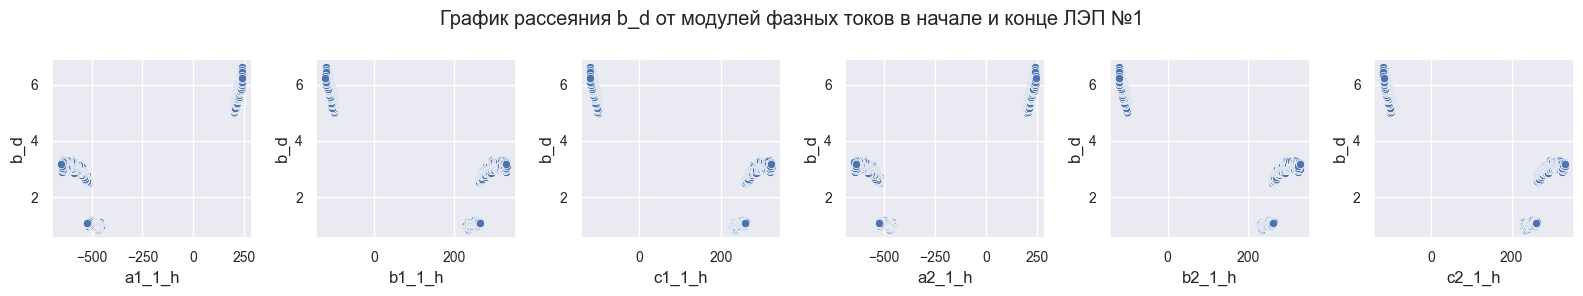

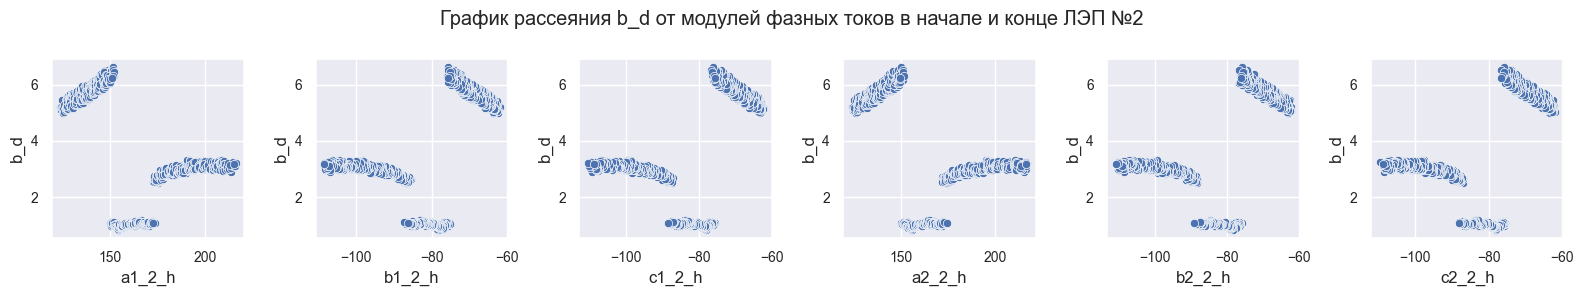

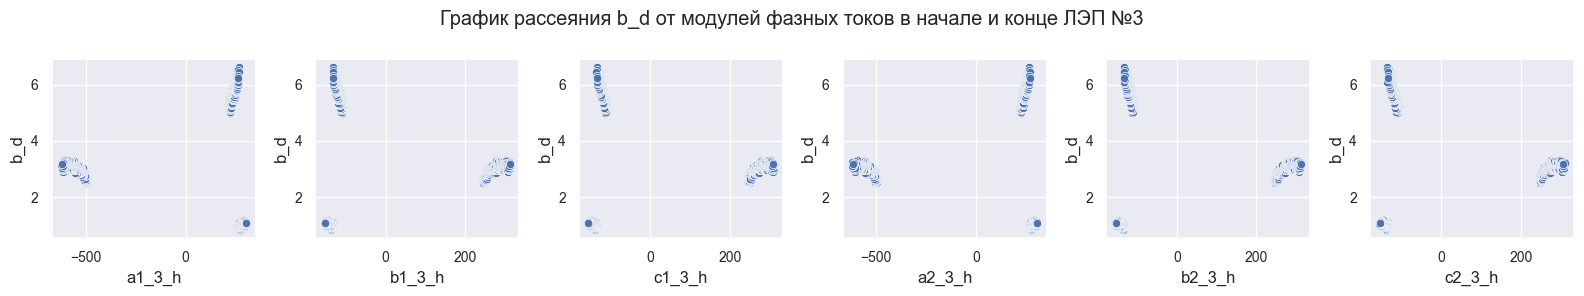

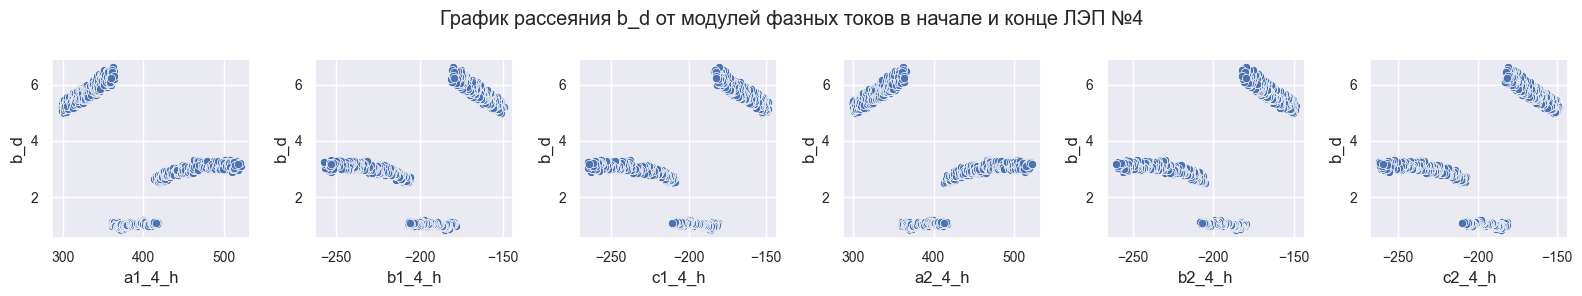

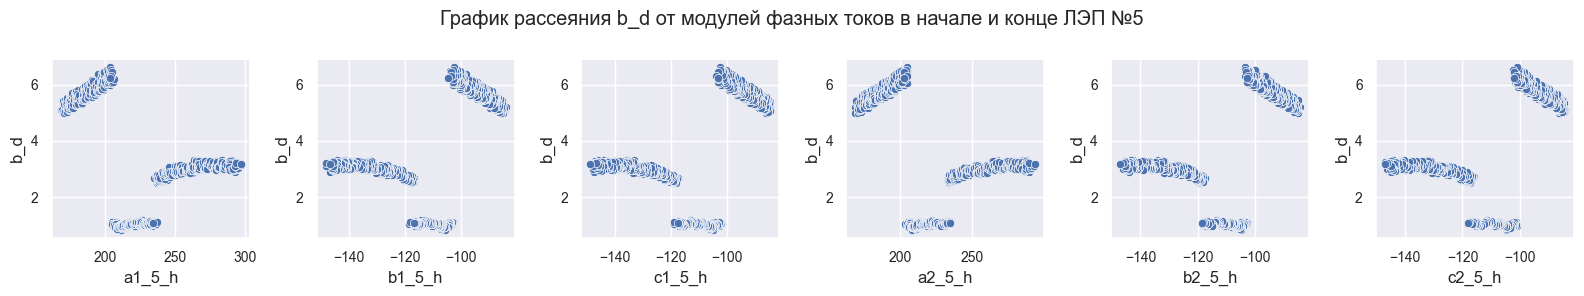

In [119]:
real_parts_predictors = df_complex.iloc[:, :-1].applymap(lambda x: x.real)
target_module = abs(df_complex.iloc[:, -1])
df_modul = pd.concat([real_parts_predictors, target_module], axis=1)
# df_modul = df_complex.applymap(lambda x: abs(x))

# Размер группы столбцов
group_size = 6

# Последний столбец
last_column = df_modul.columns[-1]

# Количество столбцов в датафрейме (кроме последнего)
num_columns = len(df_modul.columns) - 1

# Разделение столбцов на группы и создание графиков
group_number = 1  # Начальный номер группы
for i in range(0, num_columns, group_size):
    group = df_modul.columns[i:i + group_size]
    num_plots = len(group)
    
    # Создание сетки для графиков
    fig, axes = plt.subplots(1, num_plots, figsize=(16, 3))
    
    # Построение графиков рассеяния
    for j, column in enumerate(group):
        sns.scatterplot(data=df_modul, x=column, y=last_column, ax=axes[j], marker='o')
        axes[j].set_xlabel(column)
        axes[j].set_ylabel(last_column)
        axes[j].grid(True)  # Добавление линий сетки
    
    fig.suptitle(f'График рассеяния {last_column} от модулей фазных токов в начале и конце ЛЭП №{group_number}')
    group_number += 1
    plt.tight_layout()
    plt.show()

8 Среднеквадратичное значение b_d

In [120]:
std_b_d = np.sqrt(np.mean(np.abs(df_complex['b_d']) ** 2))
print(f'Среднеквадратичное значение b_d = {std_b_d.round(1)}')

Среднеквадратичное значение b_d = 3.9


9 Датасет тока небаланса для матрицы A_h и вектора b_d, заданных с погрешностями k_A и k_b

In [121]:
df_sum = pd.DataFrame()

for i in range(0, N_powerlines * N_feat, 3):
    feature_group = df_complex.iloc[:, i:i+3]  # Выбираем текущий тройной набор признаков
    sum_features = feature_group.sum(axis=1)  # Суммируем признаки в текущем тройном наборе
    df_sum[f'Jo_{i//3 + 1}'] = sum_features 

df_sum['b_d'] = df_complex['b_d']
df_sum.head()

,Jo_1,Jo_2,Jo_3,Jo_4,Jo_5,Jo_6,Jo_7,Jo_8,Jo_9,Jo_10,b_d
0,-0.813572-2.113380j,-0.200194+1.648680j,-0.556411-0.195559j,0.499016+1.142418j,1.572809-0.252378j,-2.764273-0.148751j,-1.154020-1.102091j,1.426120+2.680717j,-1.871615+0.859489j,0.340798-2.241280j,4.751648-1.821259j
1,3.092141-0.192627j,0.490195-1.870978j,-1.109873-0.742696j,-0.585476-0.791284j,1.148821+1.653314j,1.253686-0.968915j,-4.586719-1.686584j,2.328863-0.946598j,2.141394+0.627091j,-1.605737+0.230794j,4.859064-1.869849j
2,-0.268691-0.193912j,0.978548-2.442106j,0.099318+0.549419j,-1.295686+0.145081j,-0.015619-1.844675j,-0.038300+1.852101j,3.301991+2.376743j,1.730528-1.459635j,0.294023-1.349571j,0.135613+1.504762j,4.865925-1.878111j
3,-0.337736+1.014139j,-1.110184+0.275536j,0.931124-0.005396j,0.053503-1.400922j,1.465118-0.062193j,-0.122659-0.925697j,-0.919530-2.230631j,2.311017+1.443342j,0.867309-1.170663j,-1.461109+0.248182j,4.905419-1.893564j
4,2.099477-1.105933j,-1.512577-1.106473j,0.682640+1.248224j,1.646679-0.924923j,0.648325-0.884430j,-1.047210+0.450661j,-0.384733-1.356607j,-2.082269+0.680243j,-0.507823+0.845936j,1.355704-1.502138j,4.694555-1.815003j


In [122]:
# np.max(np.abs(df_complex))

10 Наибольшие значения токов фазы А в началах и концах ЛЭП

In [123]:
np.max(np.abs(df_complex.iloc[:, ::3]), axis=0)

a1_1_h    651.889826
a2_1_h    645.668793
a1_2_h    216.071584
a2_2_h    216.961211
a1_3_h    626.535201
a2_3_h    621.323745
a1_4_h    521.134605
a2_4_h    522.362259
a1_5_h    297.136710
a2_5_h    293.693573
b_d         6.636281
dtype: float64

11 Наибольшие значения токов небаланса (утроенных токов нулевой последовательности) в началах и концах ЛЭП

In [124]:
np.max(np.abs(df_sum))

c:\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Jo_1     20.536960
Jo_2     25.743991
Jo_3      8.070193
Jo_4      7.248436
Jo_5     14.534987
Jo_6     17.038426
Jo_7     21.131338
Jo_8     14.068939
Jo_9      7.170602
Jo_10     7.238797
b_d       6.636281
dtype: float64

In [125]:
# Вычисление долей наибольшего и ср.квадр. модулей тока небаланса от наибольшего модуля тока фазы А для каждой ЛЭП
df_sum = pd.DataFrame()

for i in range(0, len(df_complex.iloc[0])-1, 3):
    feature_group = df_complex.iloc[:, i:i+3]
    sum_features = feature_group.sum(axis=1)
    df_sum[f'Jo_{i//3 + 1}'] = sum_features

df_sum['b_d'] = df_complex['b_d']
df_sum.columns = df_complex.iloc[:, ::3].columns
df_unbal = np.abs(df_sum) / np.abs(df_complex.iloc[:, ::3])
max_relative_unbalance = np.max(df_unbal, axis=0)

IA_values = np.max(np.abs(df_complex.iloc[:, ::3]), axis=0)
max_values = np.max(np.abs(df_sum), axis=0)
rms_values = np.sqrt(np.mean(np.abs(df_sum) ** 2, axis=0))

IA_values = IA_values.reset_index(drop=True)
max_values.index = IA_values.index
rms_values.index = IA_values.index
max_relative_unbalance.index = IA_values.index

delta_max = max_values / IA_values
delta_rms = rms_values / IA_values
unbalance_df = pd.DataFrame({
    'IA_max, A': IA_values.round(1),
    'max(3I0/IA_max)': max_relative_unbalance,
    '3I0_max/IA_max': delta_max,
    '3I0_rms/IA_max': delta_rms
})
unbalance_df = unbalance_df.rename(index={unbalance_df.index[-1]: 'U_induced_max'})
unbalance_df.T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",651.900,645.700,216.100,217.000,626.500,621.300,521.100,522.400,297.100,293.700,6.600
max(3I0/IA_max),0.032,0.040,0.041,0.038,0.024,0.032,0.041,0.031,0.027,0.031,1.000
3I0_max/IA_max,0.032,0.040,0.037,0.033,0.023,0.027,0.041,0.027,0.024,0.025,1.000
3I0_rms/IA_max,0.010,0.012,0.015,0.015,0.007,0.009,0.016,0.011,0.010,0.010,0.593


12 Корреляционная матрица

In [126]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(df_modul.corr(method='pearson').round(2), annot=True, annot_kws={"fontsize": 9}, cmap='coolwarm', linewidth=.5)
# sns.set(rc={"xtick.labelsize":10, "ytick.labelsize":10})
# plt.xticks(rotation=35, ha='right')
# plt.title('Pearson')
# plt.show()

In [127]:
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)

print(f'Время выполнения кода: {int(minutes)} мин {seconds:.1f} сек')

Время выполнения кода: 0 мин 15.0 сек
